# Quickstart guide

``imcascade`` is a method to fit sources in astronomical images. This is accomplished using the multi-Gaussian expansion method which models the galaxy as a mixture of Gaussians. For more details please read the in-depth example. What follows is a (very) brief introduction to the basic usage of ``imcascade``.

In [1]:
# This cell is hidden from documentation but the analytic profile and psf are calculated here using the astropy definitions
import importlib
#Import jax if it exists
if importlib.util.find_spec('jax') is not None:
    import jax 
    %set_env JAX_PLATFORM_NAME=cpu
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.functional_models import Sersic2D, Moffat2D
from astropy.convolution import convolve
grid = np.arange(0,150)
X,Y = np.meshgrid(grid,grid)
s2d = Sersic2D(r_eff = 6,n = 1.5, x_0 = 75., y_0 = 75., ellip = 0.3)
im = s2d(X,Y)
im = im*250./np.sum(im)
im += (X-75.)*0.0002 + (Y-75.)*-0.0001 

grid2 = np.arange(0,31)
X,Y = np.meshgrid(grid2,grid2)
m2d = Moffat2D(gamma = 3,alpha = 3, x_0 = 15., y_0 = 15.)
psf = m2d(X,Y)
psf = psf/ np.sum(psf)

sci = convolve(im,psf) + np.random.normal(loc = 0, scale = 1e-2, size = im.shape)

env: JAX_PLATFORM_NAME=cpu


In this short example we will fit an analytic, circular, Sersic profile with $n = 1.5$, $r_e = 6$ and total flux, $F = 250$, we have convolved the profile with a Moffat PSF with $\alpha = 3$ and $\gamma = 3$ and added purely Gaussian noise.

In a hidden cell I have intialized the cutout in the 2D array ``sci`` and the pixelized PSF saved in the 2D array ``psf``. Below I show to 2D images of each

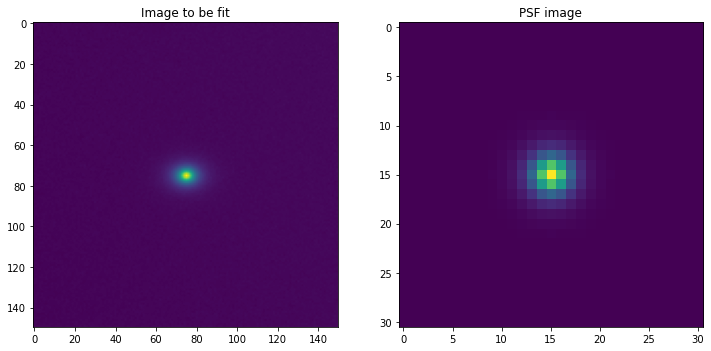

In [2]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize = (12,6))

ax1.imshow(sci)
ax1.set_title('Image to be fit')

ax2.imshow(psf)
ax2.set_title('PSF image')

plt.show()

The ``initialize_fitter`` function is designed to take a pixelized science images (as 2D arrays or fits files) and help initalize a ``Fitter`` instance which will be used below to fit galaxies. This function is designed to help users get started using our experiences to help guide some of the decisions, which may not be applicable in all situations. For more details about these choices or other options please see [the in depth example](example.ipynb) for a longer discussion about all possibilities.

In [3]:
from imcascade.fitter import initialize_fitter

fitter = initialize_fitter(sci,psf)

2022-07-12 17:48:19,219 - Fit PSF with 4 components
2022-07-12 17:48:19,220 - Widths: 1.2,1.81,5.28,2.93
2022-07-12 17:48:19,221 - Fluxes: 0.27,0.51,0.03,0.19
2022-07-12 17:48:19,231 - Using 9 components with logarithmically spaced widths to fit galaxy
2022-07-12 17:48:19,232 - 0.91, 1.52, 2.55, 4.27, 7.15, 11.97, 20.04, 33.54, 56.15
2022-07-12 17:48:19,233 - No mask was given, derriving one using sep
2022-07-12 17:48:19,246 - Using sep rms map to calculate pixel weights


This function uses the ``psf_fitter`` module to fit the given pixelized psf with a sum of Gaussians, which is required for our method. Next it estimates the effective radius and uses nine logarithmically spaced widths for the Gaussian components ranging from the PSF HWHM to $10\times r_e$. It then derrives pixel weights and masks using [sep](https://sep.readthedocs.io/en/v1.1.x/) (or the gain,exposure time and readnoise to calculate the rms). There are also options to use pre-calculated version of these if the user has them.

Now we will run our least-squares minimization routine

In [4]:
opt_param = fitter.run_ls_min()
print (opt_param)

2022-07-12 17:48:21,366 - Running least squares minimization
2022-07-12 17:48:47,347 - Finished least squares minimization


[ 7.60051373e+01  7.50005090e+01  6.87265676e-01  1.57715338e+00
  1.42502826e+00 -2.57490313e+00  1.53411116e+00  1.81786238e+00
  1.87217228e+00  1.63625068e+00  7.22478506e-01 -1.31211431e+00
  4.65480859e-01 -2.74388677e-05 -9.73687762e-05  1.91394558e-04]


We have printed out the parameters the desribe the best fit model. The first four are the structural parameters (x position, y position, axis ratio and position angle) then the next nine represent the fluxes or weights of the nine components (in logarithmic space) and the final three parameters for the tilted-plane sky model.

Obviously this is non-trivial to parse, which is why we will use our ``results`` module and the ``ImcascadeResults`` class to help us analyze the results

In [7]:
from imcascade.results import ImcascadeResults
res_class = ImcascadeResults(fitter)
res_class.run_basic_analysis()

{'flux': 252.58989931777214,
 'r20': 2.305274076411796,
 'r50': 5.940674533616872,
 'r80': 12.340978912963354,
 'r90': 17.43337150701717,
 'C80_20': 5.353367323755417,
 'C90_50': 2.934577783779577}

The function `.run_basic_analysis()` calculates some basic morphological quantities like the total flux and half-light radius. We can see that the best fit parameters match the inputs pretty well!

Another very useful function is the `.make_diagnostic_fig()` this makes a figure which helps inspect the fit

/mnt/c/Users/timbl/Documents/files/research/packages/imcascade/imcascade/results.py:707: RuntimeWarning: divide by zero encountered in true_divide
  rms_med = np.median(1./np.sqrt(fitter.weight) )


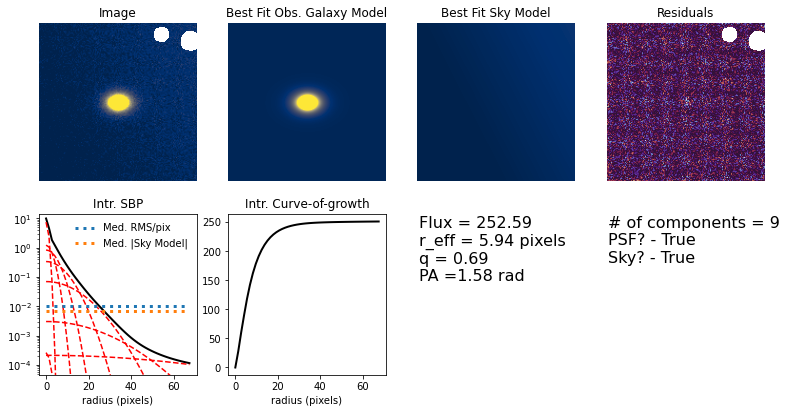

In [8]:
fig = res_class.make_diagnostic_fig()

This makes it easier to see if the fit went catastrophically wrong. This fit looks pretty good! Some examples of issues are if the curve-of-growth does not converge or if there are systematic issues in the residuals. To remedy this one could try using a different set of widths for the components, altering the inital guesses or making sure all the input data is correct.

Next we will explore the Posterior distribution using Dynesty. Specifically we will use the 'express' method which uses pre-rendered images to help speed up the run time. The code also automatically checks to see if the package `jax` is installed. This additionally helps to speed up the computation if availible.

In [ ]:
post = fitter.run_dynesty(method = 'express')

Now if we re-initialize the results class, we can calculate uncertainties on the morphological values.

In [9]:
res_class_w_post = ImcascadeResults(fitter)
res_class_w_post.run_basic_analysis()

{'flux': array([249.31304659,   1.36354565,   1.27251959]),
 'r20': array([2.3907311 , 0.01458799, 0.01400204]),
 'r50': array([5.88510278, 0.03870749, 0.03532017]),
 'r80': array([12.00401554,  0.13302446,  0.1238212 ]),
 'r90': array([16.70281417,  0.28503741,  0.2769434 ]),
 'C80_20': array([5.0199006 , 0.03832022, 0.03772956]),
 'C90_50': array([2.83774779, 0.03312112, 0.03330771])}

In [11]:
fitter.render_mode = 'erf'
%timeit fitter.make_model(opt_param, )

93.3 ms ± 6.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
from jax import jit

In [10]:
make_mod_jit = jit(fitter.make_model)
make_mod_jit(fitter.param_init)


DeviceArray([[ 0.00818884,  0.00812605,  0.00806327, ..., -0.0010408 ,
              -0.00110358, -0.00116637],
             [ 0.00817733,  0.00811455,  0.00805176, ..., -0.00105231,
              -0.00111509, -0.00117788],
             [ 0.00816582,  0.00810304,  0.00804025, ..., -0.00106382,
              -0.0011266 , -0.00118939],
             ...,
             [ 0.00660869,  0.00654147,  0.006474  , ..., -0.00273295,
              -0.00279574, -0.00285852],
             [ 0.00658118,  0.0065144 ,  0.00644742, ..., -0.00274446,
              -0.00280725, -0.00287003],
             [ 0.00655605,  0.0064897 ,  0.00642324, ..., -0.00275597,
              -0.00281876, -0.00288154]], dtype=float32)

In [ ]:
fitter.log_like

In [12]:
%timeit make_mod_jit(fitter.param_init)

499 µs ± 39.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [5]:
%timeit fitter.get_erf_stack(100,100, np.array([1,1,1]), np.array([1,1,1]), np.array([5,10,50]))


3.54 ms ± 123 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
from jax.scipy.special import erf as erf_jax
from scipy.special import erf as erf_scipy

erf_jax =jit(erf_jax)

NameError: name 'jit' is not defined

In [20]:
a = np.zeros((100,100))

In [21]:
a[50,:] = 100

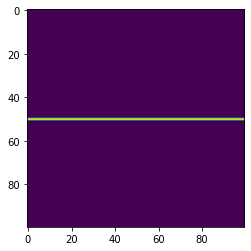

In [22]:
plt.imshow(a)

In [49]:
from jax.scipy.ndimage import map_coordinates

In [90]:
x = np.arange(a.shape[0])
y = np.arange(a.shape[1])
X,Y = np.meshgrid(x,y)

x0 = 50
y0 = 50
phi = np.pi/4.

X_rot = (X - x0)*np.cos(phi) + (Y - y0)*np.sin(phi) + x0
Y_rot = -1*(X - x0)*np.sin(phi) + (Y - y0)*np.cos(phi) + y0


In [94]:
locs = np.stack([Y_rot,X_rot])
b = map_coordinates(a,locs, order = 1 )

45.8 µs ± 4.39 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


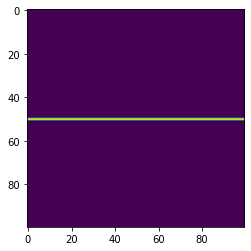

In [92]:
plt.imshow(a)

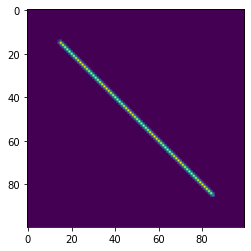

In [93]:
plt.imshow(b)

In [ ]:
from imcascade.mgm import _get_hybrid_stack